In [52]:
from run_calibrations import get_database
from dotenv import load_dotenv
load_dotenv('.env-db')
from utils.utils import *
from transformers import LlamaTokenizerFast
tokenizer = LlamaTokenizerFast.from_pretrained('hf-internal-testing/llama-tokenizer')
import pandas as pd
def count_tokens(prompt):
    return len(tokenizer.tokenize(prompt))

In [97]:
db = get_database()
# llm_name = 'openchat_v3.1/contrast'
llm_name = 'OpenAssistant/llama2-13b-orca-8k-3319'
dim = 'contrast'

all_ratings_llm = pd.DataFrame(list(db[f'queries/{llm_name}/{dim}'].find({})))

In [80]:
# dups = db['queries/reference/contrast'].aggregate([
#     {
#         '$group': {
#             '_id': {'sample_index' : '$sample_index', 'prefix_index': '$prefix_index', 'prompt_index': '$prompt_index'},
#             'dups':  {'$addToSet': "$_id"},
#             'count':  {'$sum': 1}
#         }
#     }, 
#     {
#         '$match': {
#             'count': { '$gt': 1 }
#         }
#     }
# ])
# dups = list(dups)


TypeError: unsupported operand type(s) for +: 'int' and 'str'

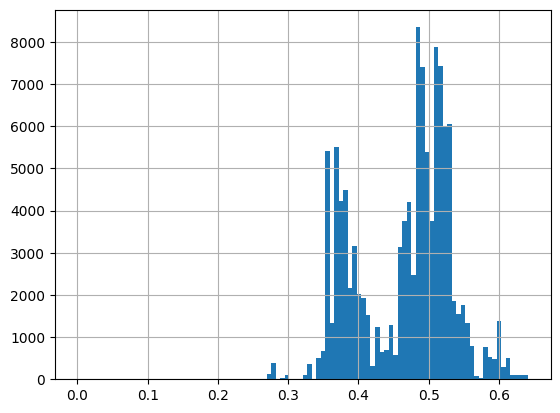

In [49]:
# reset hanging ratings
# coll_name = 'queries/contrast/openchat/openchat_v3.1'
db[coll_name].update_many({'rating':0}, {'$set':{'rating':-1}})

# get average latency
latencies = list(db[coll_name].find({"latency":{"$gt":0}}))
latencies = pd.DataFrame(latencies)
latencies['latency'].hist(bins=100)
print(f"Average latency: {sum(latencies['latency'])/len(latencies['latency'])}")

<Axes: >

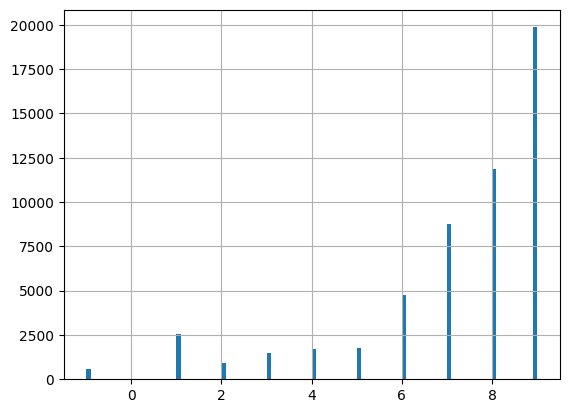

In [15]:
latencies['rating'].hist(bins=100)

In [ ]:
# import tqdm
# # display dist. of prompt lengths
# dim = 'contrast'
# prefixes = {prefix['prefix_index']:prefix for prefix in list(db['prefixes'].find({}))}
# prompts = {prompt['prompt_index']:prompt for prompt in list(db[f'core_prompts/{dim}'].find({}))}
# samples = {sample['sample_index']:sample for sample in list(db[f'samples/{dim}'].find({}))}
# tokens_dist = []
# prefix = max(prefixes.values(), key=lambda x : len(x['prefix']))
# for prompt in tqdm.tqdm(prompts):
#     for sample in samples:
#         t = count_tokens(prefix['prefix'] + prompts[prompt]['combined_prompt'] + samples[sample]['sample'])
#         tokens_dist.append(t)
pd.Series(tokens_dist).hist(bins=100)